In [1]:
from peft import LoraConfig, get_peft_model 

C:\Users\CZLZ9814\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = 'C:\Applications\Projets\diffusion-model-example'
image_path = f"{folder_path}/dataset/sprites_1788_16x16.npy"
label_path = f"{folder_path}/dataset/sprite_labels_nc_1788_16x16.npy"
save_dir = f'{folder_path}/models/'
trained_model_path = f'{save_dir}model_31.pth'
# trained_model_path = f'{save_dir}context_model_trained.pth'
context_enable = False
ddim_enable = True

import sys
sys.path.append(folder_path)
from utils import plot_utils
from utils import data_utils
from utils import sampler
from utils import trainer
from context_unet import context_unet
from context_unet import unet_config

In [3]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import HTML

# Setting Things Up

In [4]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
width = 16
height = 16 # 16x16 image

# training hyperparameters
batch_size = 100
n_epoch = 4
lrate=1e-3

In [5]:
# load unet config
# unet_config = unet_config.UnetConfig.from_pretrained("base-unet")
unet_config = unet_config.UnetConfig(input_channels=3, num_features=n_feat, num_context_features=n_cfeat, width=width, height=height)

In [6]:
# construct model
my_model = context_unet.ContextUnet(unet_config)

In [7]:
# load in pretrain model weights
my_model.load_state_dict(torch.load(trained_model_path, map_location=device))
print("Loaded in Model")

Loaded in Model


In [10]:
# peft_config = LoraConfig(target_modules=["down1", "down2", "up0", "up1", "up2"], 
#                          inference_mode=False, r=16, lora_alpha=16, 
#                          lora_dropout=0.1, bias="all")
# model = get_peft_model(my_model, peft_config)
# model.to(device)
# model.print_trainable_parameters()

# Training

In [ ]:
# load dataset and construct optimizer
dataset = data_utils.CustomDataset(image_path, label_path, data_utils.transform, context_enable=context_enable)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(my_model.parameters(), lr=lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [ ]:
# construct trainer
my_trainer = trainer.Trainer(my_model, dataloader, optim, timesteps, n_epoch, lrate, device, beta1, beta2, context_enable, save_dir)

In [ ]:
# training with context code
my_trainer.train()
print("Training Finished")

epoch 0


100%|██████████| 894/894 [09:58<00:00,  1.49it/s]


saved model at C:\Applications\Projets\diffusion-model-example/models/context_model_0.pth
epoch 1


100%|██████████| 894/894 [10:20<00:00,  1.44it/s]


epoch 2


100%|██████████| 894/894 [10:34<00:00,  1.41it/s]


epoch 3


100%|██████████| 894/894 [10:24<00:00,  1.43it/s]

saved model at C:\Applications\Projets\diffusion-model-example/models/context_model_3.pth
Training Finished


# Sampling

In [ ]:
# construct sampler and set model to eval mode
my_sampler = sampler.Sampler(model=my_model, timesteps=timesteps, width=width, height=height, device=device, beta1=beta1, beta2=beta2)
my_model.eval()

ContextUnet(
  (init_conv): ResidualConvBlock(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
  )
  (down1): UnetDown(
    (model): Sequential(
      (0): ResidualConvBlock(
        (conv1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GELU(approximate='none')
        )
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-0

In [ ]:
# visualize samples with randomly selected context
plt.clf()

ctx = None
if context_enable:
  ctx = F.one_hot(torch.randint(0, 5, (32,)), 5).to(device=device).float()

if ddim_enable:
  samples, intermediate = my_sampler.sample_ddim(32, 20, ctx)
else:
  samples, intermediate = my_sampler.sample_ddpm(32, 20, ctx)

animation_ddpm = plot_utils.plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

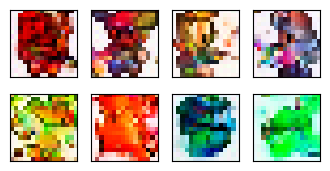

In [ ]:
# user defined context
if context_enable:
  ctx = torch.tensor([
      # hero, non-hero, food, spell, side-facing
      [1,0,0,0,0],
      [1,0,0,0,0],
      [0,0,0,0,1],
      [0,0,0,0,1],
      [0,1,0,0,0],
      [0,1,0,0,0],
      [0,0,1,0,0],
      [0,0,1,0,0],
  ]).float().to(device)
  
  if ddim_enable:
    samples, intermediate = my_sampler.sample_ddim(ctx.shape[0], 20, ctx)
  else:
    samples, intermediate = my_sampler.sample_ddpm(ctx.shape[0], 20, ctx)
    
  plot_utils.show_images(samples)

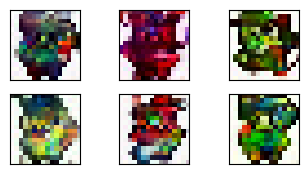

In [ ]:
# mix of defined context
if context_enable:
  ctx = torch.tensor([
      # hero, non-hero, food, spell, side-facing
      [1,0,0,0,0],      #human
      [1,0,0.6,0,0],
      [0,0,0.6,0.4,0],
      [1,0,0,0,1],
      [1,1,0,0,0],
      [1,0,0,1,0]
  ]).float().to(device)
  
  if ddim_enable:
    samples, _ = my_sampler.sample_ddim(ctx.shape[0], 20, ctx)
  else:
    samples, _ = my_sampler.sample_ddpm(ctx.shape[0], 20, ctx)
    
  plot_utils.show_images(samples)

In [ ]:
%timeit -r 1 my_sampler.sample_ddim(32, 25)
%timeit -r 1 my_sampler.sample_ddpm(32, 25)

1.64 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
29.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
